### Importing all libaries

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
import warnings
import os
import numpy as np
import tensorflow as tf
import math
warnings.filterwarnings("ignore")

Dataset developed by [Prajna](https://github.com/prajnasb/observations/tree/master/experiements/data) and Selium Web Scraping

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as is or use transfer learning to customize this model to a given task.

Let us load our base model which is **MobileNetV2** and load weights pre-trained on ImageNet. We do not include the ImageNet classifier at the top and include a new FC layer. 

[MobileNet-v2](https://machinethink.net/blog/mobilenet-v2/) is a convolutional neural network that is 157 layers deep with 3,504,872 trainable parameters. You can load a pre-trained version of the network trained on more than a million images from the ImageNet database. The pretrained network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals. As a result, the network has learned rich feature representations for a wide range of images. The network has an image input size of 224-by-224. 


MobileNets are small, low-latency, low-power models parameterized to meet the resource constraints of a variety of use cases. They can be built upon for classification, detection, embeddings and segmentation similar to how other popular large scale models, such as Inception, are used. MobileNets trade off between latency, size and accuracy while comparing favorably with popular models from the literature.

[Read paper here](https://arxiv.org/abs/1801.04381)


![mobile](images/mobilenet.png)

[Pre-trained networks](https://uk.mathworks.com/help/deeplearning/ug/pretrained-convolutional-neural-networks.html)   

Lets load the model from the Keras library.

In [4]:
baseModel = MobileNetV2(weights="imagenet", include_top=True,input_tensor=Input(shape=(224, 224, 3)))
warnings.filterwarnings("ignore")

In [5]:
len(baseModel.layers)

157

The output of the base network is typically a 7×7 pixel image. The imagenet classifier first uses a global pooling layer to reduce the size from 7×7 to 1×1 pixel and then add a dense layer to detect objects in 1000 different categories.

In [4]:
baseModel.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

### Removing top of the network.

Now lets remove the top of the network. This can be done by setting  include_top parameter as False. We do not include the ImageNet classifier at the top.

In [5]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

In [6]:
baseModel.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

Then, freeze all layers in the base model.

In [7]:
baseModel.trainable = False

In [8]:
baseModel.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

Total params: 2,257,984
Trainable params: 0
Non-trainable params: 2,257,984
__________________________________________________________________________________________________


### Replace Final layers

Create a new model on top.

In [9]:
headModel = AveragePooling2D(pool_size=(7, 7))(baseModel.output) #downsample
headModel = Flatten(name="flatten")(headModel) # used to flatten the input of the base model
headModel = Dense(128, activation="relu")(headModel) #  a dense layer is simply a layer where each unit or neuron is connected to each neuron in the next layer. The main advantage of using the ReLU function over other activation functions is that it does not activate all the neurons at the same time
headModel = Dropout(0.5)(headModel) # Dropout is a regularization technique, which aims to reduce the complexity of the model with the goal to prevent overfitting. 
headModel = Dense(2, activation="softmax")(headModel)


#### Now lets join our basemodel and the top of the model.

These new layers will learn features specific to our dataset. Since we only have two classes, the model will learn faster.

In [10]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________________________________________________________________________________________

In [12]:
163968 + 258  

164226

## Data Preperation

Pre-processing your images involves the following steps:
  1. Resizing them to the input of your CNN.
  2. Converting them to an image array.
  3. Scaling them for your neural net.
  4. Convering labels into one hot encoders, since CNNs output probability distributions!

In [13]:
mask=[]
nomask=[]
labels=[]
for i in os.listdir('data4/mask'):
    i=os.path.join('data4/mask',i)
    mask.append(preprocess_input(img_to_array(load_img(i, target_size=(224, 224)))))
    labels.append(1)
print(len(labels))

for i in os.listdir('data4/nomask'):
    i=os.path.join('data4/nomask',i)
    nomask.append(preprocess_input(img_to_array(load_img(i, target_size=(224, 224)))))
    labels.append(0)
print(len(labels))

2538
4796


In [14]:
print('Total:',len(labels))
print('Mask:',len(mask), 'Ratio:',str(round(len(mask)/len(labels)*100,3))+'%')
print('No Mask:',len(nomask),str(round(len(nomask)/len(labels)*100,3))+'%')

Total: 4796
Mask: 2538 Ratio: 52.919%
No Mask: 2258 47.081%


In [15]:
data= np.array(mask+nomask, dtype="float32" )
labels = to_categorical(np.array(labels))

Because CNN output probability of whether a person is wearing a mask or not, we need to convert one hot encode our classes.

In [16]:
labels

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [17]:
print(data.shape)

(4796, 224, 224, 3)


In [18]:
print(labels.shape)

(4796, 2)


Create your test and training sets.

In [19]:
from sklearn.model_selection import train_test_split

(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)

print(trainX.shape)
print(testX.shape)
print(trainY.shape)
print(testY.shape)

(3836, 224, 224, 3)
(960, 224, 224, 3)
(3836, 2)
(960, 2)


### Data Augmentation

Common ways to augment data for your deep learning models.
   * Rotation
   * Width Shifting
   * Height Shifting
   * Brightness
   * Shear Intensity
   * Zoom
   * Channel Shift
   * Horizontal Flip
   * Vertical Flip

Our goal is to ensure that the network sees new images that it has never seen before at each and every epoch to improve model generalization.

[Data Augmentation](https://nanonets.com/blog/data-augmentation-how-to-use-deep-learning-when-you-have-limited-data-part-2/)

[Data Augmentation Parameters](https://mc.ai/image-data-augmentation-image-processing-in-tensorflow-part-2/)

[Types of Data Augmentation](https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/)

The Keras [**ImageDataGenerator**](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) translates each image in our batch (According to batch size) by a series of random transformations and returns transfomed images. This is also known as **In-place/on-the-fly data augmentation**

In [20]:
aug = ImageDataGenerator(rotation_range=20,zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,
                         shear_range=0.15,horizontal_flip=True)

In [21]:
try:
    os.mkdir('modelweights2')
except FileExistsError:
    pass


### Set up a call back to monitor Model Performance

We set up [Checkpoints](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) at every interation (epochs) to monitor model performance and we monitor the validation accuracy to load weights of the model that has the achieved the highest accuracy.

Options include:

   * Whether to only keep the model that has achieved the **best performance** so far.
   * Whether to save the model at the end of every epoch regardless of performance.
   * Definition of 'best'; which quantity to monitor and whether it should be maximized or minimized.
   * The frequency it should save at. Currently, the callback supports saving at the end of every epoch, or after a  fixed number of training batches.
   * Whether only weights are saved, or the whole model is saved


In [22]:
checkpoint_filepath = 'modelweights2/weights.{epoch:02d}-{val_acc:.3f}.hdf5'

# save_weights_only 	if True, then only the model's weights will be saved else whole model is saved.
# filepath- where to save the model or

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath= checkpoint_filepath,save_weights_only=True,
    monitor='val_acc', #monitor validation accuracy
    mode='max', #mode
    save_best_only=True) #only weights where improvement has been shown will be saved.

Read on [Batch Size](https://arxiv.org/abs/1609.04836) here:

**Parameters:**

   * [**optimizer**](https://medium.com/octavian-ai/which-optimizer-and-learning-rate-should-i-use-for-deep-learning-5acb418f9b2), Adam learns the fastest. Adam is more stable than the other optimizers, it doesn’t suffer any major decreases in accuracy. Read more on how to schedule custom learning rates using Keras [**LearningRateScheduler**](https://www.pyimagesearch.com/2019/07/22/keras-learning-rate-schedules-and-decay/)
   
   * [**loss**](https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/) function use binary cross-entropy if only two classes in the dataset.

   * **steps_per_epoch** should typically be equal to **ceil(num_samples / batch_size).** 
   
   * The [**batch size**](https://arxiv.org/abs/1609.04836) defines the number of samples that will be propagated through the network. Larger batch sizes result in faster progress in training, but don't always converge as fast. Smaller batch sizes train slower, but can converge faster. Batch size is problem dependent. It won't make a huge difference for your problem unless you're training on hundreds of thousands or millions of observations.  

In [23]:
INIT_LR = 1e-4
EPOCHS = 30
BS = 32

print('train steps per epoch',math.ceil(len(trainX) / BS))

print('test steps per epoch',math.ceil(len(testX) / BS))

train steps per epoch 120
test steps per epoch 30


In [24]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the head of the network
print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=math.ceil(len(trainX) / BS),
    validation_data=(testX, testY),
    validation_steps=math.ceil(len(testX) / BS),
    epochs=EPOCHS,
    callbacks=[model_checkpoint_callback])

[INFO] training head...
Epoch 1/30
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
120/120 [==============================] - 1014s 8s/step - loss: 0.5664 - acc: 0.7049 - val_loss: 0.3924 - val_acc: 0.8271
Epoch 2/30
120/120 [==============================] - 659s 5s/step - loss: 0.3563 - acc: 0.8488 - val_loss: 0.2985 - val_acc: 0.8698
Epoch 3/30
120/120 [==============================] - 625s 5s/step - loss: 0.2657 - acc: 0.8973 - val_loss: 0.2795 - val_acc: 0.8760
Epoch 4/30
120/120 [==============================] - 626s 5s/step - loss: 0.2340 - acc: 0.9054 - val_loss: 0.2291 - val_acc: 0.9010
Epoch 5/30
120/120 [==============================] - 613s 5s/step - loss: 0.2131 - acc: 0.9205 - val_loss: 0.2711 - val_acc: 0.8854
Epoch 6/30
120/120 [==============================] - 607s 5s/step - loss: 0.1906 - acc: 0.9291 - val_loss: 0.2501 - val_acc: 0.8917
Epoch 7/30
120/120 [==============================] - 602s 5s/step - loss: 0.1868 -

Now lets load our best model weights.

In [26]:
model.load_weights('modelweights2/weights.30-0.951.hdf5')

### Evaulate Classification Performance

In [30]:
from sklearn.metrics import classification_report
predictions = model.predict(testX, batch_size=BS)

print(classification_report(testY.argmax(axis=1), np.argmax(predictions, axis=1)))

model.save("save.model4", save_format="h5")

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       452
           1       0.96      0.95      0.95       508

    accuracy                           0.95       960
   macro avg       0.95      0.95      0.95       960
weighted avg       0.95      0.95      0.95       960



In [31]:
def plot_confusion_matrix(Y,y_pred,labels=None):
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
    import seaborn as sns
    cf_matrix = confusion_matrix(Y,y_pred)
    group_names =  ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
        
    fig, ax = plt.subplots(figsize=(18,6))   
    l=['no mask','mask']
    
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='coolwarm',cbar=True,ax=ax, xticklabels=l, yticklabels=l)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

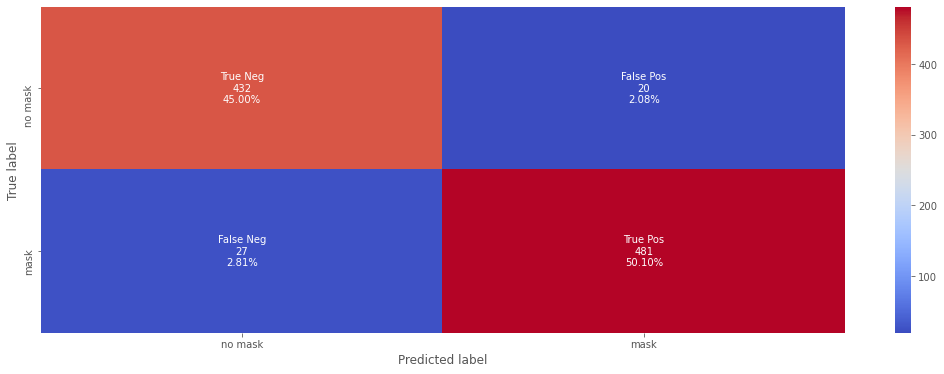

In [33]:
plot_confusion_matrix(testY.argmax(axis=1), np.argmax(predictions, axis=1),labels=None)

### Plot Learning Curves

**Train Learning Curve:** Learning curve calculated from the training dataset that gives an idea of how well the model is learning.

**Validation Learning Curve:** Learning curve calculated from a hold-out validation dataset that gives an idea of how well the model is generalizing.

There are three common dynamics that you are likely to observe in learning curves; they are:

1. Underfit.
2. Overfit.
3. Good Fit.

#### Underfit Learning Curves

Underfitting occurs when the model is not able to obtain a sufficiently low error value on the training set.


An underfit model may also be identified by a training loss that is decreasing and continues to decrease at the end of the plot.

This indicates that the model is capable of further learning and possible further improvements and that the training process was halted prematurely.

#### Overfit Learning Curves

Overfitting refers to a model that has learned the training dataset too well, including the statistical noise or random fluctuations in the training dataset.

Overfit curves usually have high validation losses and low training losses.

#### Good Fit Learning Curves

A plot of learning curves shows a good fit if:

1. The plot of training loss decreases to a point of stability.
2. The plot of validation loss decreases to a point of stability and has a small gap with the training loss.

Read more [here](https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/)

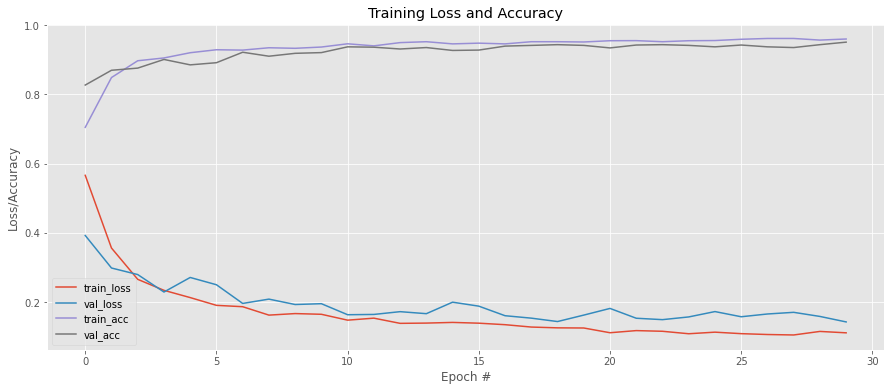

In [35]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure(figsize=(15, 6))
plt.plot(np.arange(0, EPOCHS), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, EPOCHS), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, EPOCHS), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, EPOCHS), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

There are slight cases of overfitting but the model can be used nonetheless!